In [26]:
include("../LiPoSID.jl")

using LinearAlgebra

using DynamicPolynomials

using SymPy

using Plots

using Dates

using HDF5

data_dir = "../DATA/"

γ_list = [ "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133",  "79.477", "251.33"]

γ_list_disp = [ "0.0795",  "0.2513", "0.7947", "2.5133", "7.9477", "25.133",  "79.477", "251.33"];

b⁰ = [0, 0, 1, 1]
b¹ = [0, 0, -1, 1]
bˣ = [1, 0, 0, 1]
bʸ = [1, 1, 0, 1]


function ⊗(A::AbstractMatrix, B::AbstractMatrix)
    return kron(A,B)
end

function LME_operator_symbolic(H, J)
    
    Id = I(2)   
    U = -im*(Id ⊗ H - transpose(H) ⊗ Id)
    D = sum( 2*transpose(j')⊗j-Id⊗(j'*j) - transpose(j)*transpose(j')⊗Id for j in J )/2 
    
    Lᴸᴹᴱ = U + D
    
    return Lᴸᴹᴱ
end

function SumCoeffs2(poly, s)
    p = SymPy.expand(poly)
    rest_poly = SymPy.subs(p, s => 0)
    degrees = range(1,convert(Int32,SymPy.degree(p, s)))
    
    obj = sum(p.coeff(s^i)^2 for i in degrees) #+ rest_poly^2  
    
    return obj
end 

function sympy_to_dynamicpoly(sympy_expr::Sym) #
    # Extract variables from the SymPy expression
    vars = free_symbols(sympy_expr)

    # Convert SymPy variables to string and then to Symbol
    var_symbols = [Symbol(string(v)) for v in vars]

    # Create DynamicPolynomials variables using @polyvar macro
    @eval begin
        @polyvar $(var_symbols...)
    end

    # Map SymPy variables to DynamicPolynomials variables
    var_map = Dict(vars[i] => eval(var_symbols[i]) for i in 1:length(vars))

    # Substitute using subs and convert to DynamicPolynomial
    dynamic_poly_expr = SymPy.subs(sympy_expr, var_map)
    dynamic_poly = eval(Meta.parse(string(dynamic_poly_expr)))
    return dynamic_poly
end


function TF_objective(Aˢʸᵐᵇ, Aˢⁱᵈ, b)

    @syms s

    Gˢʸᵐᵇ = inv(I(4)*s - Aˢʸᵐᵇ)*b

    Gˢⁱᵈ = inv(I(4)*s - Aˢⁱᵈ)*b

    #ΔG = SymPy.together.(Gˢʸᵐᵇ[1:3] - Gˢⁱᵈ[1:3])
    ΔG = SymPy.together.(Gˢʸᵐᵇ - Gˢⁱᵈ)

    polys = SymPy.numerator.(ΔG)

    obj = sum(SumCoeffs2.(polys.^2, s))

    #objective = sympy_to_dynamicpoly(obj)

    return obj

end

function read_Ac(models_file_name, γ)
    h5open(models_file_name, "r") do file
        Ac = read(file["gamma_"*string(γ)]["Ac"])
        return Ac
    end
end

function dmd_Ac(γ)

    data_dir = "../DATA/"
    
    ρᵉ, tᵉ = LiPoSID.get_rho_series(data_dir*"State_B1_2CUT_data.h5", γ)
    ρᵍ, tᵍ = LiPoSID.get_rho_series(data_dir*"State_B2_2CUT_data.h5", γ)
    ρˣ, tˣ = LiPoSID.get_rho_series(data_dir*"State_B3_2CUT_data.h5", γ)
    ρʸ, tʸ = LiPoSID.get_rho_series(data_dir*"State_B4_2CUT_data.h5", γ)

    Δt = tᵉ[2]-tᵉ[1]

    lᵉ = length(ρᵉ); lᵍ = length(ρᵍ); lˣ = length(ρˣ); lʸ = length(ρʸ)
    lᵐᵃˣ = min(lᵉ, lᵍ,  lˣ, lʸ)  #choose time limit by shortest series

    Aᴰᴹᴰ⁻ˢᴮ = LiPoSID.direct_DMD_01XY_b4_A([ρᵉ[1:lᵐᵃˣ], ρᵍ[1:lᵐᵃˣ], ρˣ[1:lᵐᵃˣ], ρʸ[1:lᵐᵃˣ]])
    Acᴰᴹᴰ⁻ˢᴮ = log(Aᴰᴹᴰ⁻ˢᴮ)/Δt

    return Acᴰᴹᴰ⁻ˢᴮ

end

function sb_TF_objective(γ, Acˢʸᵐᵇ)
    models_file_name="../MODELS/DMD_b4_LTI_trn4_2023-Nov-29_at_17-38.h5"
    Acᴰᴹᴰ = read_Ac(models_file_name, γ)
    obj =  TF_objective(Acˢʸᵐᵇ, Acᴰᴹᴰ, bˣ) + TF_objective(Acˢʸᵐᵇ, Acᴰᴹᴰ, bʸ) + TF_objective(Acˢʸᵐᵇ, Acᴰᴹᴰ, b¹)
    objective = sympy_to_dynamicpoly(obj)
    return objective
end

#Functions for plotting heatmaps

function plot_TF_objective(γ, Aᴸᴹᴱ)

    objective = sb_TF_objective(γ, Aᴸᴹᴱ)

    function f(γ_val, ω_val)
        return objective(variables(objective)[1] => γ_val, variables(objective)[2] => ω_val)
    end
    
    function f(γ_val)
        return objective(variables(objective)[1] => γ_val)
    end

    γᶠ = parse(Float64, γ)

    w = range(-30, 30, length=1000)
    g = range(-30*γᶠ, 30*γᶠ, length=1000)
    #g = range(-10, 10, length=500)
    z = @. f(g', w)

    heatmap(g, w, log.(z))
    title!("γ = "*string(γ))

    #contour(g, w, log.(z))

end


plot_TF_objective (generic function with 1 method)

In [10]:
models_file_name="../MODELS/DMD_b4_LTI_trn4_2023-Nov-29_at_17-38.h5"
Acᴰᴹᴰ = read_Ac(models_file_name, γ_list[4])

4×4 Matrix{Float64}:
 -1.09539e-6   -25.1327        0.000678345   0.000288167
 25.4256        -2.5375       -0.000944828  -0.00272287
 -0.218801      -0.0565769    -2.5393        2.46159
  4.41832e-13   -1.77842e-12   4.25337e-13   4.75864e-13

In [11]:
ω = SymPy.symbols("ω", real=true)
γ = SymPy.symbols("γ", real=true)

Hᴸᴹᴱ = [ ω        0
         0        0   ]


Jᴸᴹᴱ = [ 0     γ
         0     0. + 0im  ]

Lᴸᴹᴱ = LME_operator_symbolic(Hᴸᴹᴱ, [Jᴸᴹᴱ])

M =   [ 0  0    1  1
        1  -im  0  0 
        1  im   0  0
        0  0   -1  1 ]/2

Aˢ = [ -γ/2  ω      0      0  
       -ω   -γ/2    0      0
        0    0     -γ      γ
        0    0      0      0    ] #==#

Aᴸᴹᴱ = real.(inv(M) * Lᴸᴹᴱ * M)

4×4 Matrix{Sym{PyCall.PyObject}}:
 -0.5*γ^2     1.0⋅ω         0        0
   -1.0⋅ω  -0.5*γ^2         0        0
        0         0  -1.0*γ^2  1.0*γ^2
        0         0         0        0

In [19]:
γ_tst = γ_list[4]

obj = sb_TF_objective(γ_tst, Aᴸᴹᴱ)

9.904175521655992e62γ¹⁶ + 2.4344716550100415e65γ¹⁴ + 1.5846680834649588e64γ¹²ω² + 4.655360774633789e65γ¹²ω + 2.3509838281349196e67γ¹² + 2.9213659860120492e66γ¹⁰ω² + 9.508008500789747e64γ⁸ω⁴ + 8.630170993379823e67γ¹⁰ω + 5.58643292956055e66γ⁸ω³ + 8.842082362178287e68γ¹⁰ + 2.715886596473223e68γ⁸ω² + 1.1685463944048183e67γ⁶ω⁴ + 2.5354689335439293e65γ⁴ω⁶ + 5.469954759833557e69γ⁸ω + 6.90413679470386e68γ⁶ω³ + 2.23457317182422e67γ⁴ω⁵ + 2.977613927201025e70γ⁸ + 1.3971337824958324e70γ⁶ω² + 1.0442370396738179e69γ⁴ω⁴ + 1.5580618592064215e67γ²ω⁶ + 2.535468933543924e65ω⁸ + 1.2636407969782138e71γ⁶ω + 2.8815136612772895e70γ⁴ω³ + 1.3808273589407713e69γ²ω⁵ + 2.979430895765625e67ω⁷ + 1.6520910628709802e71γ⁶ + 3.4482667953422774e71γ⁴ω² + 4.173801952034808e70γ²ω⁴ + 1.336159254344464e69ω⁶ + 5.145903029798791e71γ⁴ω + 4.618599980832878e71γ²ω³ + 2.774127029375471e70ω⁵ + 4.823179300036851e71γ⁴ + 9.608373506491208e71γ²ω² + 2.4923092748285877e71ω⁴ + 9.863530882913545e71γ²ω + 6.428402453692123e71ω³ + 6.15100975673

In [20]:
function coef_range(obj)
    maximum(abs.(coefficients(obj)))/minimum(abs.(coefficients(obj)))
end

coef_range(obj)

9.958962117893028e8

In [21]:
using JLD2
save_object("objective.jld2", obj)

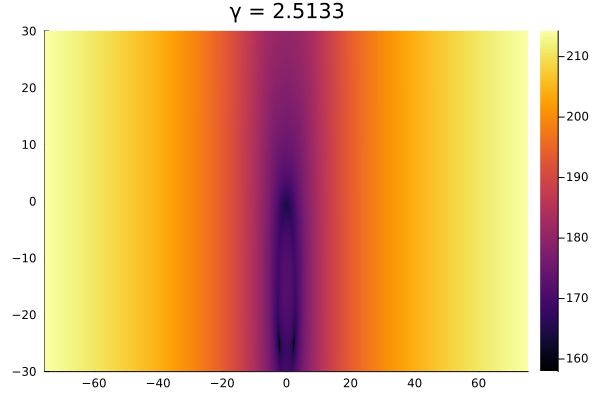

In [27]:
plot_TF_objective(γ_tst , Aᴸᴹᴱ)